### 导包，设定超参数

In [4]:
# from methods.our_method import Our_method
# from methods.trans_lasso import Trans_lasso
# from methods.t_lasso import T_lasso
# from methods.least_square import Least_square


# from evaluator.evaluator import *
# # from evaluator.sample_generator import *
# from tqdm import tqdm
# from matplotlib import pyplot as plt
# import time
# import numpy as np

In [1]:
n_features=16
n_samples=100
n_packs=101
s=16

In [5]:
from methods.estiminator import estiminator
import numpy as np
from sklearn.linear_model import Lasso
import time
from tqdm import tqdm

class Our_method(estiminator):
    def __init__(self, n_features=0,s=0,L=0,instance=None):
        if instance is not None:
            super(Our_method, self).__init__(instance.n_features,instance.s,instance.L)
        else:
            assert n_features>0 and s>0 and L>0
            super(Our_method, self).__init__(n_features,s,L)
      
    #这个方法没有用到，目的是方便使用梯度下降等方法，将更新方法放到模型里面去  
    def likelihood(self, beta, delta, samples_pack):
        beta=beta+delta
        X=samples_pack.getX()
        y=samples_pack.getY()
        # 似然函数为高斯分布
        return -np.sum((y-np.dot(X,beta))**2)
    
    #更新beta
    #输入：delta:辅助模型与目标模型的回归系数差矩阵，v:辅助模型是否被选择的向量，samples_packs:样本数据
    # 优化问题：argmax_{beta} l_0(beta)+sum_{k=1}^{K}(l_k(beta,delta[k])-lambda*||delta||_2)*v[k]
    def update_beta(self, delta, v, samples_packs):
        # 对于线性模型，该问题有显式解
        # 该显式解为beta=(x0^T*x0+sum_{k=1}^{K}v[k]*xk^T*xk-lambda*E)^{-1}*(x0^T*y0+sum_{k=1}^{K}v[k]*xk^T*yk-sum_{k=1}^{K}v[k]*xk^T*xk*delta[k])
        # x0,y0为目标模型的样本数据
        # xk,yk为第k个辅助模型的样本数据
        
        #mat1=x0^T*x0+sum_{k=1}^{K}v[k]*xk^T*xk-lambda*E
        lamb=0.001
        mat1=np.dot(samples_packs[0].getX().T,samples_packs[0].getX())
        # mat1-=lamb*np.eye(len(samples_packs[0].getX()[0]))
        for i in range(len(samples_packs)-1):
            if v[i]==1:
                mat1+=np.dot(samples_packs[i+1].getX().T,samples_packs[i+1].getX())
        #mat2=x0^T*y0+sum_{k=1}^{K}v[k]*xk^T*yk
        mat2=np.dot(samples_packs[0].getX().T,samples_packs[0].getY())
        for i in range(len(samples_packs)-1):
            if v[i]==1:
                mat2+=np.dot(samples_packs[i+1].getX().T,samples_packs[i+1].getY())
        #mat3=sum_{k=1}^{K}v[k]*xk^T*xk*delta[k]
        mat3=np.zeros(len(samples_packs[0].getX()[0]))
        for i in range(len(samples_packs)-1):
            if v[i]==1:
                mat3+=np.dot(samples_packs[i+1].getX().T,np.dot(samples_packs[i+1].getX(),delta[i]))
        beta=np.dot(np.linalg.inv(mat1),mat2-mat3)
        return beta
    
    #更新delta
    #输入：beta:当前beta，sample_pack:该模型的样本数据
    #输出：更新后的delta_k
    def update_delta_k(self,beta,sample_pack):  
        # 该优化问题为: argmin_{delta_k} ||y_k-x_k*beta-x_k*delta_k||_2^2+lambda*||delta_k||_2
        # 该问题好像没有显式解，但函数是凸函数，可以使用梯度下降法求解
        # 目标函数在0处不可导
        # -?先比较lambda与||X.T*y||_2的大小，如果lambda大，则delta_k=0
        # -?使用IHT迭代算法求解
        lamb=0.1#-?
        X=sample_pack.getX()
        y=sample_pack.getY()
        y=y-np.dot(X,beta)#优化delta
        if lamb>=np.linalg.norm(np.dot(X.T,y)):
            return np.zeros(len(X[0]))
        else:
            #使用IHT方法迭代求解
            #先测试一下
            #L是X的最大奇异值
            U,sigma,VT=np.linalg.svd(X)
            Lipschitz=sigma[0]*sigma[0]
            # print(Lipschitz)
            max_iter=100
            #岭回归结果作为初值
            delta=np.dot(np.linalg.inv(np.dot(X.T,X)+lamb*np.eye(len(X[0]))),np.dot(X.T,y))
            delta2=delta+0
            for i in range(max_iter):
                #计算梯度
                grad=np.dot(X.T,np.dot(X,delta)-y)
                b=delta-1/Lipschitz*grad
                # assert 2*lamb/Lipschitz<np.linalg.norm(b)#初始条件保证不可能进这里
                delta=(1-lamb/(Lipschitz*np.linalg.norm(b)))*b
                if np.linalg.norm(delta-delta2)<0.0001:
                    break
                delta2=delta
            return delta
        
    
    # 非iid分布式迁移学习与数据源选择
    # delta[k]=beta[k]-beta[0] 为第k个辅助模型与目标模型的回归系数差
    # 上述参数均为n_features维向量
    # v[k]属于{0,1},为第k个辅助模型是否被选择
    # 优化问题：argmax_{beta,delta[k],v[k]} l_0(beta)+sum_{k=1}^{K}(l_k(beta,delta[k])-lambda*||delta||_2)*v[k]
    # s.t. ||v||_0=L
    # l_k为模型的似然函数，当前模型为线性模型，似然函数为高斯分布
    # 使用两步迭代算法求解
    # 第一步：固定v[k]，求解beta[0],delta[k]
    # 求解beta与delta时也使用两步迭代算法
    # 第二步：固定beta[0],delta[k]，求解v[k]
    # 重复以上两步直到收敛（或达到最大迭代次数）
    # -?没有设置收敛条件，目前仅仅设置了最大迭代次数
    # 输入：samples_packs:样本数据，s:目标模型稀疏度，L:选定的辅助模型个数
    def fit(self, samples_packs,s=0,L=0):
        #如果model_num==0,则直接使用目标模型的样本数据进行lasso估计
        if s==0:
            s=self.s
        if L==0:
            L=self.L
        model_num=len(samples_packs)-1
        if model_num==0:
            lasso=Lasso(alpha=0.01)
            lasso.fit(samples_packs[0].getX(),samples_packs[0].getY())
            #保留绝对值前s大个-?有意义吗？
            self.params=lasso.coef_
            return lasso.coef_,[],[],[]
        # 初始化参数
        # -?第一次迭代时使用全部模型,v=[1,1,1,1,...]
        #计算程序运行时间
        start_time=time.time()
        times=[]
        times.append(time.time()-start_time)
        
        v=np.ones(len(samples_packs)-1)
        v1=np.ones(len(samples_packs)-1)
        # beta为目标模型的回归系数
        beta=np.zeros(len(samples_packs[0].getX()[0]))
        delta=np.zeros((len(samples_packs)-1,len(samples_packs[0].getX()[0])))
        # 迭代求解
        max_iter=10
        # 设置算法的退出阈值threshold
        threshold=0.001
        beta1=np.ones(len(samples_packs[0].getX()[0]))
        beta2=np.ones(len(samples_packs[0].getX()[0]))
        for i in range(max_iter):
            # 第一步:交替求解beta与delta
            if i==0:
                times.append(time.time()-start_time)
            for j in range(max_iter):
                beta=self.update_beta(delta,v,samples_packs)
                #计算beta与beta2的差的2范数
                if np.linalg.norm(beta-beta2)<threshold:
                    break
                beta2=beta
                if i==0:
                    times.append(time.time()-start_time)
                #对K个辅助模型分别更新其delta_k
                for k in range(len(samples_packs)-1):
                    delta[k]=self.update_delta_k(beta,samples_packs[k+1])
                if i==0:
                    times.append(time.time()-start_time)
            if np.linalg.norm(beta-beta1)<threshold:
                break
            beta1=beta
            # 第二步：更新v
            # 选择delta的q范数最小的L个模型，将其对应的v设为1，其余设为0。
            # 目前选择q=2
            if i==0:
                times.append(time.time()-start_time)
            v=np.zeros(len(samples_packs[1:]))
            v[np.argsort(np.linalg.norm(delta,axis=1))[:L]]=1
            if np.linalg.norm(v-v1)<threshold:#-?除了beta不变之外，加入了v不变的退出条件。实际上这两个退出的效果是一样的（吗？）
                break
            v1=v
            if i==0:
                times.append(time.time()-start_time)
        # 返回beta
        # -?暂时不设置稀疏度-?设置了一下
        #保留绝对值前s大个
        # beta[np.argsort(np.abs(beta))[:-s]] = 0
        self.params=beta
        return beta,delta,v

### 测试1：t11（独立同分布、同质、固定差异），与lasso对比

In [3]:
models=[Our_method(n_features,s,1),T_lasso(n_features,s,1)]
#L=2,4,8,12,16,20 -?没有做L=0的代码
#多次实验取平均
import multiprocessing
workers=multiprocessing.cpu_count()
result_list=[]
for h in [2,6]:
    result_list.append([])
    for L in tqdm([2,4,8,12,16,20,24,28,32,36,40]):
    # for L in tqdm([2,4,8,12]):
        result_list[-1].append([])
        eval=evaluator(repeat_times=1,model_num=len(models))
        for i in range(60):
            sample_packs,coef_true=t11_eval(n_features,s,n_packs,n_samples,h,L)
            eval.append(models,sample_packs,coef_true,s,L,False)
        eval.run(workers)
        result_list[-1][-1]=eval.result_list
#将result_list保存下来
result_list=np.array(result_list)
# np.save('result_list7-1.npy',result_list)

100%|██████████| 11/11 [31:08<00:00, 169.88s/it]


In [4]:
result_list.shape

(2, 11, 2, 60)

In [5]:
result=np.mean(result_list,axis=3)
#将第二个轴和第三个轴交换
result=np.swapaxes(result,1,2)

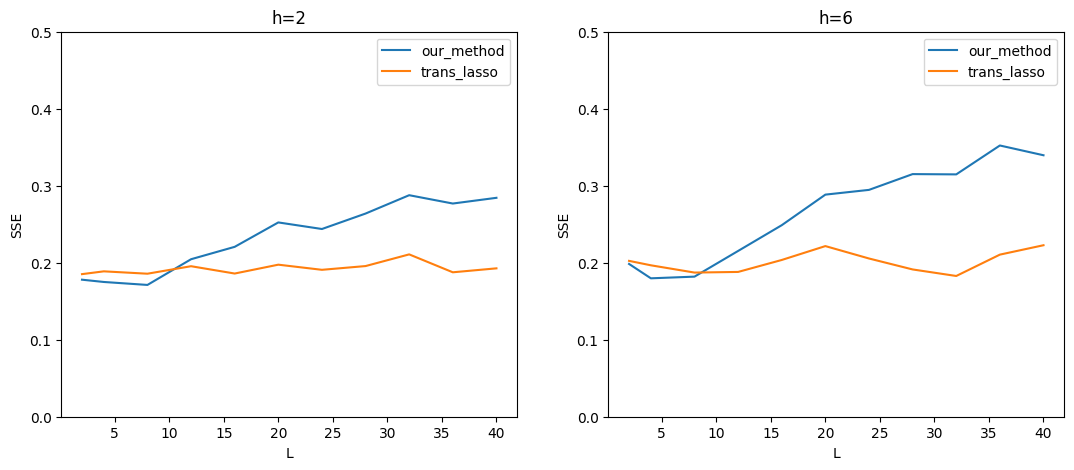

In [7]:
#画图，横轴是L，纵轴是SSE，依照h分三张图
fig=plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,0,:],label='our_method')
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,1,:],label='trans_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,2,:],label='t_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,3,:],label='least_square')
plt.legend()
plt.xlabel('L')
plt.ylabel('SSE')
#设置y的范围为0~0.5
plt.ylim(0,0.5)
plt.title('h=2') 

plt.subplot(1,3,2)
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,0,:],label='our_method')
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,1,:],label='trans_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,2,:],label='t_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,3,:],label='least_square')
plt.legend()
plt.xlabel('L')
plt.ylabel('SSE')
#设置y的范围为0~0.5
plt.ylim(0,0.5)
plt.title('h=6')

# plt.subplot(1,3,3)
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[2,0,:],label='our_method')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[2,1,:],label='trans_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[2,2,:],label='t_lasso')
# plt.legend()
# plt.xlabel('L')
# plt.ylabel('SSE')
# #设置y的范围为0~0.5
# # plt.ylim(0,0.5)
# plt.title('h=12') 

#设置图像大小
plt.show()

### 测试2：indep（same），与lasso对比

In [11]:
models=[Our_method(n_features,s,1),T_lasso(n_features,s,1)]
#L=2,4,8,12,16,20 -?没有做L=0的代码
#多次实验取平均
import multiprocessing
workers=multiprocessing.cpu_count()
result_list=[]
for h in [2,6]:
    result_list.append([])
    for L in tqdm([2,4,8,12,16,20,24,28,32,36,40]):
    # for L in tqdm([2,4,8,12]):
        result_list[-1].append([])
        eval=evaluator(repeat_times=1,model_num=len(models))
        for i in range(60):
            sample_packs,coef_true=indep_eval(n_features,s,n_packs,n_samples)
            eval.append(models,sample_packs,coef_true,s,L,False)
        eval.run(workers)
        result_list[-1][-1]=eval.result_list
#将result_list保存下来
result_list=np.array(result_list)
# np.save('result_list7-1.npy',result_list)

100%|██████████| 11/11 [35:32<00:00, 193.85s/it]


In [12]:
result_list.shape

(2, 11, 2, 60)

In [13]:
result=np.mean(result_list,axis=3)
#将第二个轴和第三个轴交换
result=np.swapaxes(result,1,2)

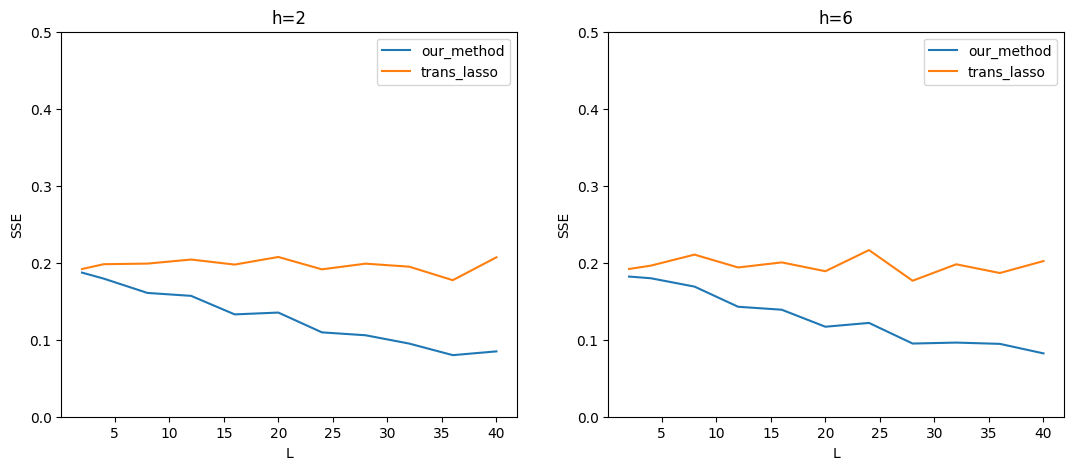

In [14]:
#画图，横轴是L，纵轴是SSE，依照h分三张图
fig=plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,0,:],label='our_method')
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,1,:],label='trans_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,2,:],label='t_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[0,3,:],label='least_square')
plt.legend()
plt.xlabel('L')
plt.ylabel('SSE')
#设置y的范围为0~0.5
plt.ylim(0,0.5)
plt.title('h=2') 

plt.subplot(1,3,2)
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,0,:],label='our_method')
plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,1,:],label='trans_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,2,:],label='t_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[1,3,:],label='least_square')
plt.legend()
plt.xlabel('L')
plt.ylabel('SSE')
#设置y的范围为0~0.5
plt.ylim(0,0.5)
plt.title('h=6')

# plt.subplot(1,3,3)
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[2,0,:],label='our_method')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[2,1,:],label='trans_lasso')
# plt.plot([2,4,8,12,16,20,24,28,32,36,40],result[2,2,:],label='t_lasso')
# plt.legend()
# plt.xlabel('L')
# plt.ylabel('SSE')
# #设置y的范围为0~0.5
# # plt.ylim(0,0.5)
# plt.title('h=12') 

#设置图像大小
plt.show()

## 调试

In [11]:
import random
# 考虑后期以该类模拟不同数据的分布，对取数据加以时间限制等
class samples_pack:
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def get_n_fretures(self):
        return len(self.X[0])
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def getX(self):
        return self.X
    def getY(self):
        return self.y

# 生成样本数据
#   
def coef_gen(coef, cov, noise_mean, noise_var, n_samples):
    # 生成特征
    X = np.random.multivariate_normal(np.zeros(len(coef)), cov, n_samples)
    # 生成噪声
    noise = np.random.normal(noise_mean, noise_var, n_samples)
    # 生成标签
    y = np.dot(X, coef) + noise
    return X, y

def indep_eval(n_features,s,n_packs,n_samples):
    coef_true = np.zeros(n_features)
    coef_true[:s] = 0.3
    samples_packs=[]
    # 设定超参数：各模型回归系数、特征间的协方差矩阵、噪声的均值与方差
    # 长度为n_features, 其中前s个为非零回归系数，后n_features-s个为零
    #生成样本
    for i in range(n_packs):
        cov = np.eye(n_features)
        delta = np.zeros(n_features)
        #delta=e*i*0.01
        # delta[:]=0.01*i
        coef=coef_true+delta
        noise_mean = 0
        noise_var = 1
        X, y = coef_gen(coef, cov, noise_mean, noise_var, n_samples)
        samples_packs.append(samples_pack(X, y))
    return samples_packs,coef_true

def t11_eval(n_features,s,n_packs,n_samples,h,L):
    coef_list=[]
    coef_true = np.zeros(n_features)
    coef_true[:s] = 0.3
    # coef_list.append(coef_true)
    samples_packs=[]
    # 设定超参数：各模型回归系数、特征间的协方差矩阵、噪声的均值与方差
    # 长度为n_features, 其中前s个为非零回归系数，后n_features-s个为零
    #生成样本
    for i in range(n_packs):
        cov = np.eye(n_features)
        delta = np.zeros(n_features)
        #在0~n_features之间随机选取h个位置，将其回归系数减0.3
        if i==0:
            pass
        elif i<L+1:
            random_list=random.sample(range(n_features),h)
            delta[random_list]=-0.2
        else:
            random_list=random.sample(range(n_features),12)
            delta[random_list]=-0.5
        coef=coef_true+delta
        coef_list.append(coef)
        noise_mean = 0
        noise_var = 1
        X, y = coef_gen(coef, cov, noise_mean, noise_var, n_samples)
        samples_packs.append(samples_pack(X, y))
    return samples_packs,coef_true,coef_list

In [4]:
n_features=16
n_samples=100
n_packs=101
s=16

In [19]:
model=Our_method(n_features,s,1)

result_list=[]
SSE_list=[]
h=6
for L in tqdm([2,4,8,12,16,20,24,28,32,36,40]):
    SSE=0
    for i in range(1):
        sample_packs,coef_true=t11_eval(n_features,s,n_packs,n_samples,h,L)
        output=model.fit(sample_packs,s,L)
        beta,delta,v,time=output
        SSE+=np.linalg.norm(beta-coef_true)
        result_list.append(output)
    SSE/=(i+1)
    SSE_list.append(SSE)

100%|██████████| 11/11 [02:43<00:00, 14.88s/it]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (11, 4) + inhomogeneous part.

怎么这么慢？

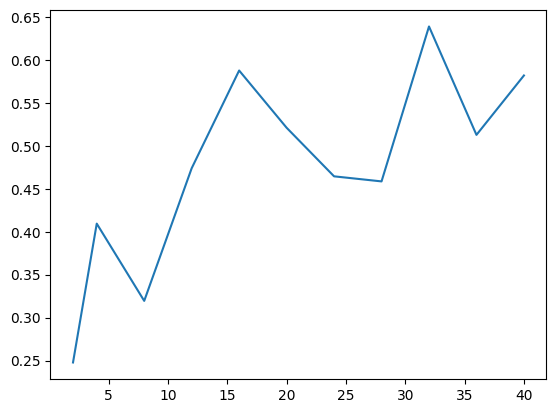

In [25]:
plt.plot([2,4,8,12,16,20,24,28,32,36,40],SSE_list)

In [26]:
result_list[4]

(array([0.15280754, 0.02308959, 0.39230022, 0.15322755, 0.27028353,
        0.34904061, 0.25888705, 0.13440547, 0.15722922, 0.02239347,
        0.07237067, 0.23071295, 0.25037257, 0.2377157 , 0.20776874,
        0.17596816]),
 array([[ 0.31200687,  0.43081386, -0.10415752, ..., -0.06275937,
          0.15458481,  0.04218067],
        [ 0.04166365,  0.17402005, -0.23656813, ...,  0.04006957,
          0.14308445, -0.00896652],
        [-0.09800639,  0.17134645, -0.19126163, ..., -0.17566893,
          0.1976249 , -0.21484747],
        ...,
        [ 0.11055836, -0.35531981, -0.47104139, ..., -0.62082193,
         -0.02907757, -0.40069944],
        [-0.01544885, -0.21281934, -0.09292983, ..., -0.30384612,
         -0.57228536, -0.5258882 ],
        [-0.52326653, -0.07417124, -0.70768071, ..., -0.27275839,
         -0.48224502, -0.21501262]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## 调试2

In [ ]:
n_features=16
n_samples=100
n_packs=101
s=16
model=Our_method(n_features,s,1)

result_list=[]
SSE_list=[]
h=6
L=16
SSE=0
for i in tqdm(range(1)):
    sample_packs,coef_true,coef_list=t11_eval(n_features,s,n_packs,n_samples,h,L)
    output=model.fit(sample_packs,s,L)
    beta,delta,v=output
    SSE+=np.linalg.norm(beta-coef_true)
    result_list.append(output)
SSE/=(i+1)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:54<00:00, 54.09s/it]


In [7]:
SSE

0.45557504625386347

In [8]:
output

(array([0.3006354 , 0.18270709, 0.22400635, 0.29747579, 0.25098844,
        0.18678748, 0.02568585, 0.38448796, 0.33527595, 0.24342468,
        0.33292412, 0.24169674, 0.31024202, 0.20405042, 0.37704625,
        0.0426525 ]),
 array([[-0.34524105,  0.10652286, -0.16828097, ..., -0.01692341,
         -0.20073116,  0.1566751 ],
        [-0.29229514, -0.09605199, -0.02815423, ...,  0.21908915,
         -0.33264275,  0.31422361],
        [-0.07650145, -0.00106799, -0.11733212, ...,  0.13361767,
          0.11647046,  0.1870778 ],
        ...,
        [-0.62449888, -0.25971777, -0.33710032, ..., -0.20285005,
         -0.80087638, -0.21259247],
        [-0.68371018, -0.42760325, -0.37890012, ..., -0.28263794,
         -0.41878303,  0.19167719],
        [-0.49223389, -0.33299597, -0.31137416, ..., -0.4346751 ,
         -0.36126313, -0.14801989]]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [13]:
coef_list[1:]

[array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3]),
 array([0.1, 0.3, 0.1, 0.3, 0.1, 0.1, 0.3, 0.3, 0.3, 0.1, 0.3, 0.1, 0.3,
        0.3, 0.3, 0.3]),
 array([0.3, 0.1, 0.3, 0.3, 0.3, 0.3, 0.1, 0.1, 0.3, 0.1, 0.1, 0.3, 0.3,
        0.3, 0.1, 0.3]),
 array([0.1, 0.3, 0.3, 0.3, 0.1, 0.3, 0.1, 0.3, 0.3, 0.1, 0.1, 0.3, 0.1,
        0.3, 0.3, 0.3]),
 array([0.3, 0.3, 0.1, 0.3, 0.3, 0.3, 0.1, 0.1, 0.1, 0.3, 0.1, 0.3, 0.1,
        0.3, 0.3, 0.3]),
 array([0.3, 0.3, 0.1, 0.3, 0.3, 0.1, 0.3, 0.1, 0.3, 0.3, 0.1, 0.3, 0.3,
        0.1, 0.3, 0.1]),
 array([0.3, 0.3, 0.3, 0.1, 0.3, 0.1, 0.1, 0.3, 0.1, 0.3, 0.1, 0.3, 0.3,
        0.1, 0.3, 0.3]),
 array([0.1, 0.3, 0.1, 0.1, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.1, 0.1, 0.3,
        0.3, 0.3, 0.1]),
 array([0.3, 0.3, 0.1, 0.3, 0.1, 0.3, 0.3, 0.1, 0.1, 0.1, 0.3, 0.3, 0.3,
        0.3, 0.1, 0.3]),
 array([0.3, 0.3, 0.1, 0.3, 0.3, 0.1, 0.1, 0.1, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.1, 0.1, 0.3]),
 array([0.3, 0.3, 0.